In [23]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from pypfopt import risk_models, expected_returns
from pypfopt import BlackLittermanModel, EfficientFrontier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [15]:
# 자산 리스트
asset_list = [
    'AAPL',  # 애플
    'MSFT',  # 마이크로소프트
    'GOOGL', # 알파벳
    'AMZN',  # 아마존
    'JNJ',   # 존슨앤드존슨
    'JPM',   # JP모건 체이스
    'V',     # 비자
    'PG',    # 프록터앤드갬블
    'KO',    # 코카콜라
    'XOM',   # 엑손모빌
    'BND',   # 미국 종합 채권 ETF
    'TLT',   # 장기 국채 ETF
    'GLD',   # 금 ETF
    'XLV',   # 헬스케어 섹터 ETF
    'XLU'    # 유틸리티 섹터 ETF
]


In [29]:
# 데이터 수집 기간 설정
start_date = '2015-01-01'
end_date = '2023-10-01'

# 가격 데이터 수집
price_data = yf.download(asset_list, start=start_date, end=end_date)['Adj Close']

# 결측치 처리
price_data = price_data.fillna(method='ffill').fillna(method='bfill')

# 수익률 계산
returns = price_data.pct_change().dropna()


[*********************100%%**********************]  15 of 15 completed
C:\Users\rkddk\AppData\Local\Temp\ipykernel_23388\938213765.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.fillna(method='ffill').fillna(method='bfill')


In [27]:
# 시장 균형 포트폴리오 가중치 설정 (단순 평균)
market_weights = dict(zip(asset_list, [1/len(asset_list)] * len(asset_list)))

# 시장 균형 수익률 계산 (CAPM 기반)
market_prior = expected_returns.capm_return(price_data, risk_free_rate=0.02)


In [30]:
# 시장 균형 포트폴리오 가중치 설정 (단순 평균)
market_weights = dict(zip(asset_list, [1/len(asset_list)] * len(asset_list)))

# 시장 균형 수익률 계산 (CAPM 기반)
# pypfopt의 capm_return 함수는 'market_prices' 인자를 사용하여 시장 수익률을 계산
# 여기서는 시장 포트폴리오의 수익률을 가정합니다. 실제로는 벤치마크 지수를 사용할 수 있습니다.
market_prior = expected_returns.capm_return(price_data, risk_free_rate=0.02)

# 투자자 견해 설정
# 노인 투자자가 더 높은 수익률을 기대하는 자산에 대한 견해를 설정
views = {
    'AAPL': 0.15,  # 애플의 예상 수익률 15%
    'MSFT': 0.12,  # 마이크로소프트의 예상 수익률 12%
    'AMZN': 0.10,  # 아마존의 예상 수익률 10%
    'GOOGL': 0.11, # 알파벳의 예상 수익률 11%
    'JNJ': 0.08    # 존슨앤드존슨의 예상 수익률 8%
}

# 견해의 불확실성 설정 (신뢰도)
# 리스트 형태로, views의 순서와 일치해야 함
view_confidences = [0.05, 0.04, 0.06, 0.05, 0.03]

In [32]:
# 블랙-리터만 모델 생성
bl = BlackLittermanModel(
    cov_matrix=risk_models.sample_cov(returns),
    pi=market_prior,
    absolute_views=views,
    omega="idzorek",
    view_confidences=view_confidences,
    tau=0.025  # 보통 0.025~0.05 사이의 값을 사용
)

# 새로운 기대 수익률 및 공분산 행렬 계산
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

# 포트폴리오 최적화
ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe(risk_free_rate=0.02)
cleaned_weights = ef.clean_weights()

# 포트폴리오 성과 출력
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)



Expected annual return: 15.2%
Annual volatility: 6629.3%
Sharpe Ratio: 0.00


In [33]:
print("\n최적 포트폴리오 가중치:")
for asset, weight in cleaned_weights.items():
    print(f"{asset}: {weight:.2%}")


최적 포트폴리오 가중치:
AAPL: 7.64%
AMZN: 2.48%
BND: 5.22%
GLD: 1.26%
GOOGL: 1.60%
JNJ: 7.04%
JPM: 6.81%
KO: 12.35%
MSFT: 16.97%
PG: 5.72%
TLT: 0.00%
V: 11.70%
XLU: 11.13%
XLV: 0.00%
XOM: 10.08%


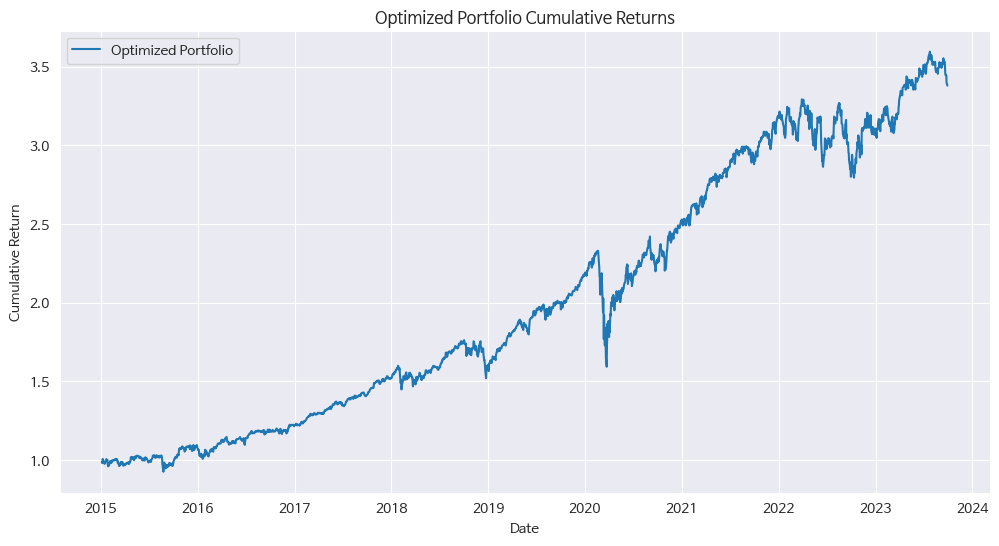

In [35]:
portfolio_returns = returns[list(cleaned_weights.keys())].dot(list(cleaned_weights.values()))
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Optimized Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


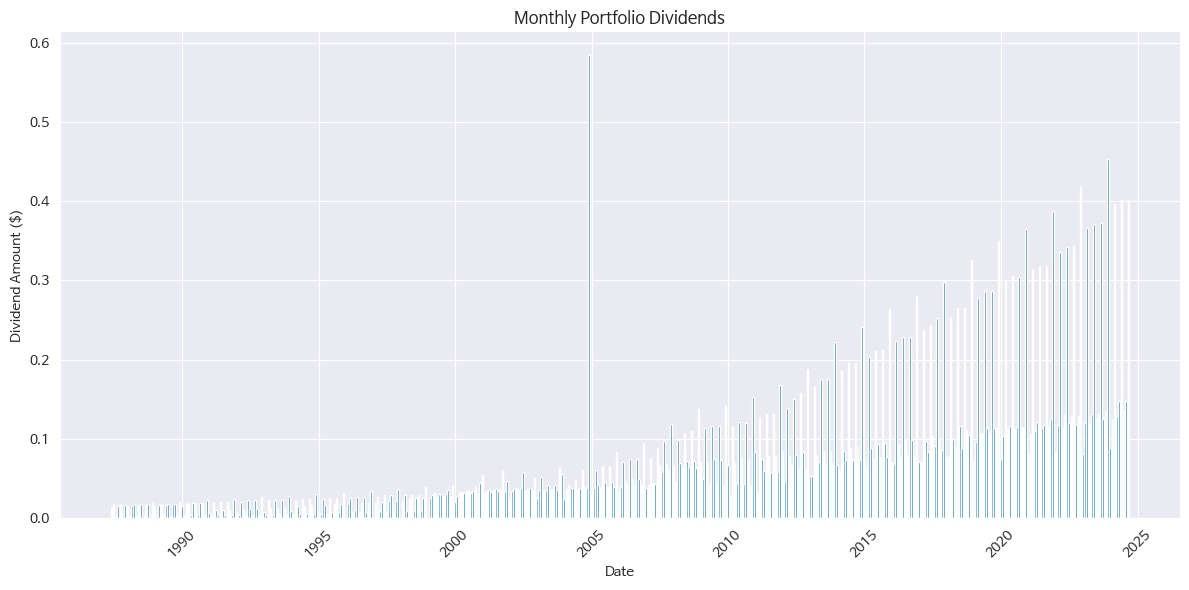

In [36]:
dividend_data = pd.DataFrame()
for asset in asset_list:
    ticker = yf.Ticker(asset)
    dividends = ticker.dividends
    dividends = dividends.resample('M').sum()  # 월별 배당금 합산
    dividend_data[asset] = dividends

# 결측치 처리
dividend_data = dividend_data.fillna(0)

# 포트폴리오 배당금 계산
portfolio_dividends = dividend_data.multiply(cleaned_weights, axis=1)
portfolio_dividends['Total_Dividend'] = portfolio_dividends.sum(axis=1)

# 월별 배당금 히스토그램 시각화
plt.figure(figsize=(12,6))
plt.bar(portfolio_dividends.index, portfolio_dividends['Total_Dividend'], width=20)
plt.title('Monthly Portfolio Dividends')
plt.xlabel('Date')
plt.ylabel('Dividend Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Maximum Drawdown: -31.65%


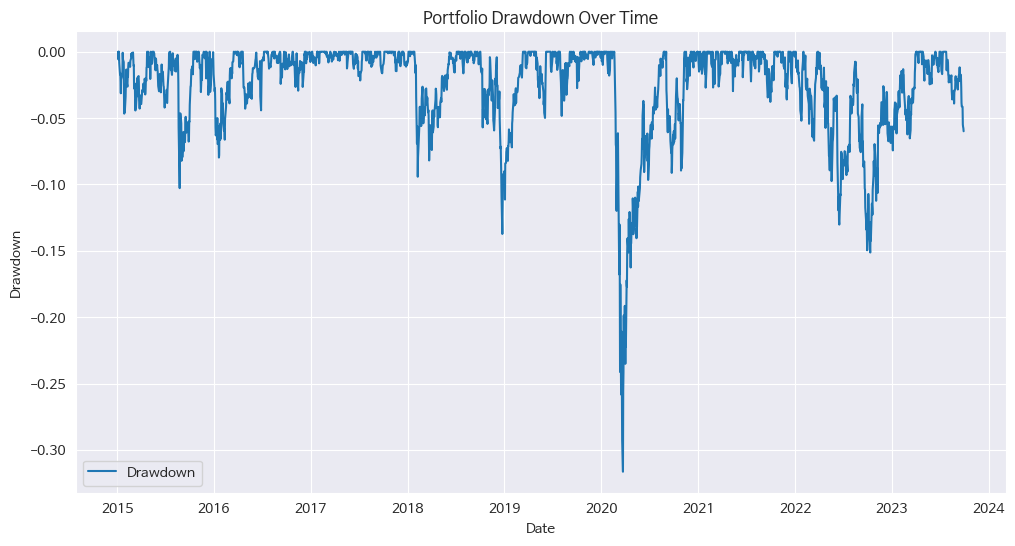

Annualized Volatility: 16.69%
Value at Risk (95% confidence): -1.51%

리스크 지표:
             Maximum Drawdown Annualized Volatility VaR (95% confidence)
Risk Metrics          -31.65%                16.69%               -1.51%


In [37]:
# 최대 낙폭 계산
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# 낙폭 시각화
plt.figure(figsize=(12,6))
plt.plot(drawdown, label='Drawdown')
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

# 연환산 변동성 계산
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
print(f"Annualized Volatility: {annualized_volatility:.2%}")

# Value at Risk (VaR) 계산 (95% 신뢰 수준)
confidence_level = 0.95
VaR_95 = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
print(f"Value at Risk (95% confidence): {VaR_95:.2%}")

# 리스크 지표 표로 정리
risk_metrics = pd.DataFrame({
    'Maximum Drawdown': [f"{max_drawdown:.2%}"],
    'Annualized Volatility': [f"{annualized_volatility:.2%}"],
    'VaR (95% confidence)': [f"{VaR_95:.2%}"]
}, index=['Risk Metrics'])

print("\n리스크 지표:")
print(risk_metrics)